In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_parquet("data/raw/france.parquet")
data.dropna(axis=0, how='any', inplace=True)

position = pd.read_csv("data/raw/postesSynop.csv", sep=";")

Id = position["ID"].astype(str)
for i in range(len(Id)):
    if len(Id[i]) < 5:
        Id[i] = '0' + Id[i]

production = pd.read_parquet("data/raw/franceagrimer-rdts-surfs-multicrops.parquet")
production = production.drop(production[production["n_dep"] == "2A"].index)
production = production.drop(production[production["n_dep"] == "2B"].index)
production = production.drop(production[production["n_dep"].astype(int) > 95].index)

provinces = {7005: 80, 7015: 59, 7020: 50, 7027: 14, 7037: 76, 7072: 51, 7110: 29, 7117: 22, 7130: 35, 7139: 61, 7149: 91, 7168: 10, 7181: 54, 7190: 67, 7207: 56, 7222: 44, 7240: 37, 7255: 18, 7280: 21, 7299: 68, 7314: 17, 7335: 86, 7434: 87, 7460: 63, 7471: 43, 7481: 69, 7510: 33, 7535: 46, 7558: 12, 7577: 26, 7591: 5, 7607: 40, 7621: 65, 7627: 9, 7630: 31, 7643: 34, 7650: 13, 7661: 83, 7690: 6, 7747: 66, 67005: 10}

crops = production["crop"].unique()
stations = data["id_sta"].unique()

In [ ]:
lr = LinearRegression()

# Single Element Regression by Month

In [4]:
times = 10000

In [11]:
def init_y(data_list):
    for i in data_list:
        n_dep0, year, month = i.split('_')
        if n_dep0 + "_" + str(year) not in total_rdt:
            r_year = production['n_dep'].map(lambda x : x == n_dep0)
            r_crop = production['crop'].map(lambda x : x == crop)
            rdt = production[r_year & r_crop]["rdt_" + str(year)].values
            if rdt.size > 0:
                if rdt[0]:
                    total_rdt[n_dep0 + "_" + str(year)] = rdt[0]


def init(month, data_list):
    init_y(data_list)
    return init_list(month)


def predict_zero():
    predict_zero = rdt_array.mean()
    
    RMSE = math.sqrt(((predict_zero - rdt_array) ** 2).sum() / len(rdt_array))
    rRMSE = RMSE / rdt_array.mean()
    
    return rRMSE


def predict_n(n, times):
    if n == 0:
        return predict_zero(), 0.0

    sum_RMSE = 0
    coef = np.array([0.0 for i in range(n)])
    
    for i in range(times):
        X_train, X_test, y_train, y_test = train_test_split(data_array, rdt_array, test_size=0.2)
        X_train_n = X_train
        X_test_n = X_test
        for i in range(2, n + 1):
            X_train_n = np.concatenate([X_train ** i, X_train_n], axis=1)
            X_test_n = np.concatenate([X_test ** i, X_test_n], axis=1)
        
        lr.fit(X_train_n, y_train)
        coef += lr.coef_
        y_predict_n = lr.predict(X_test_n)
        
        RMSE = math.sqrt(((y_predict_n - y_test) ** 2).sum() / len(y_test))
        rRMSE = RMSE / y_test.mean()
        
        sum_RMSE += rRMSE

    return sum_RMSE / times, coef / times


def test_degree_n(times, month):
    degree = np.linspace(start, end, end - start + 1)
    for i in degree:
        rRMSE_degree_month[crop + "_" + i.astype(int).astype(str) + "_" + str(month)], coeffs[crop + "_" + i.astype(int).astype(str) + "_" + str(month)] = predict_n(i.astype(int), times)


def find_best_degree_each_month():
    for crop in crops:
        for month in range(1, 13):
            best_degree = start
            best_RMSE = rRMSE_degree_month[crop + "_" + str(start) + "_" + str(month)]
            for degree in range(start + 1, end - start + 1):
                if rRMSE_degree_month[crop + "_" + str(degree) + "_" + str(month)] < best_RMSE:
                    best_RMSE = rRMSE_degree_month[crop + "_" + str(degree) + "_" + str(month)]
                    best_degree = degree
            best_rRMSE_month[crop + "_" + str(best_degree) + "_" + str(month)] = best_RMSE

        
def draw():
    for i in best_rRMSE_month:
        crop, degree, month = i.split("_")
        if crop + "_" + str(month) not in month_best:
            month_best[crop + "_" + str(month)] = rRMSE_degree_month[i]
            month_best_degree[crop + "_" + str(month)] = degree
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    plt.xticks(np.arange(1, 13, 1))
    for crop in crops:
        rRMSE_plot = []
        x_plot = np.linspace(1, 12, 12)
        for i in x_plot:
            rRMSE_plot.append(month_best[crop + "_" + i.astype(int).astype(str)])
        plt.plot(x_plot, rRMSE_plot)
    plt.legend(crops)

## Consider One Month

### rr24

In [6]:
def init_x():
    for i in stations:
        if i in provinces:
            data_station = data[data["id_sta"] == i]
            day_position = 0

            for j in range(2017, 2023):
                for m in range(1, 13):
                    rain = 0
                    if data_station.index[day_position].year == j:
                        if data_station.index[day_position].month == m:
                            for d in range(day_position, len(data_station)):
                                if data_station.index[d].month == m:
                                    rain += data_station["rr24"][d]
                                else:
                                    day_position = d
                                    break
                            total_rain[str(provinces[i]) + "_" + str(j) + "_" + str(m)] = rain

In [7]:
def init_list(month):
    data_list = []
    rdt_list = []

    for i in total_rdt:
        if i + "_" + str(month) in total_rain:
            data_list.append(np.array([total_rain[i + "_" + str(month)]]))
            rdt_list.append(total_rdt[i])

    data_list = np.array(data_list)
    rdt_list = np.array(rdt_list)
    
    return data_list, rdt_list

In [8]:
start = 0
end = 10

In [9]:
rRMSE_degree_month = {}
total_rain = {}
coeffs = {}
best_rRMSE_month = {}

init_x()

for crop in crops:
    for month in range(1, 13):
        total_rdt = {}

        data_array, rdt_array = init(month)

        test_degree_n(times, month)

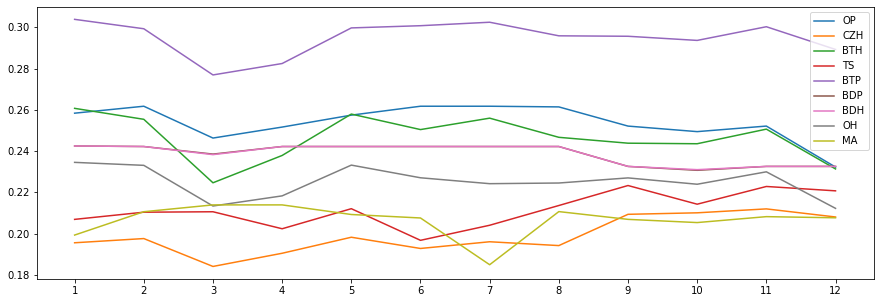

In [10]:
month_best = {}
month_best_degree = {}

find_best_degree_each_month()
draw()

In [11]:
best_predict = {}

for crop in crops:
    temp_list = []
    for i in range(1, 13):
        temp_list.append(month_best[crop + "_" + str(i)])
    best_predict[crop + "_" + str(temp_list.index(min(temp_list)) + 1)] = min(temp_list)

best_predict

{'OP_12': 0.2322071656091863,
 'CZH_3': 0.18402993443741308,
 'BTH_3': 0.22460202427856701,
 'TS_6': 0.19669659688099006,
 'BTP_3': 0.2768964786436296,
 'BDP_10': 0.2306520700715159,
 'BDH_10': 0.23096868949161753,
 'OH_12': 0.2121983578323222,
 'MA_7': 0.18486863862671044}

In [12]:
degree_best = {}

for i in best_predict:
    degree_best[i] = month_best_degree[i]

degree_best

{'OP_12': '3',
 'CZH_3': '4',
 'BTH_3': '4',
 'TS_6': '2',
 'BTP_3': '3',
 'BDP_10': '1',
 'BDH_10': '2',
 'OH_12': '3',
 'MA_7': '2'}

In [13]:
best_coeffs = {}

for s in best_predict:
    s_temp = s.split("_")
    s_temp = s_temp[0] + "_" + degree_best[s] + "_" + s_temp[1]
    best_coeffs[s_temp] = coeffs[s_temp]
        
best_coeffs

{'OP_3_12': array([ 1.13168290e-05, -5.68615336e-03,  8.03849839e-01]),
 'CZH_4_3': array([-2.06209502e-07,  8.10195758e-05, -1.14342489e-02,  6.15454664e-01]),
 'BTH_4_3': array([-5.07160451e-07,  2.13185283e-04, -3.26206541e-02,  1.88163703e+00]),
 'TS_2_6': array([-0.00045741,  0.12414807]),
 'BTP_3_3': array([ 6.81444449e-05, -1.94414208e-02,  1.47899202e+00]),
 'BDP_1_10': array([-0.03889005]),
 'BDH_2_10': array([-0.0003129 ,  0.03378415]),
 'OH_3_12': array([ 1.24653990e-05, -6.37508791e-03,  9.00927689e-01]),
 'MA_2_7': array([-0.00135654,  0.42478025])}

### DJ_0

In [6]:
def init_x():
    for i in stations:
        if i in provinces:
            data_station = data[data["id_sta"] == i]
            day_position = 0

            for j in range(2017, 2023):
                for m in range(1, 13):
                    rad_0 = 0
                    if data_station.index[day_position].year == j:
                        if data_station.index[day_position].month == m:
                            for d in range(day_position, len(data_station)):
                                if data_station.index[d].month == m:
                                    rad_0 += data_station["DJ_0"][d]
                                else:
                                    day_position = d
                                    break
                            total_rad_0[str(provinces[i]) + "_" + str(j) + "_" + str(m)] = rad_0

In [7]:
def init_list(month):
    data_list = []
    rdt_list = []

    for i in total_rdt:
        if i + "_" + str(month) in total_rad_0:
            data_list.append(np.array([total_rad_0[i + "_" + str(month)]]))
            rdt_list.append(total_rdt[i])

    data_list = np.array(data_list)
    rdt_list = np.array(rdt_list)
    
    return data_list, rdt_list

In [8]:
start = 0
end = 10

In [19]:
times = 10000

In [ ]:
rRMSE_degree_month = {}
total_rad_0 = {}
coeffs = {}
best_rRMSE_month = {}

init_x()

for crop in crops:
    for month in range(1, 13):
        
        total_rdt = {}

        data_array, rdt_array = init(month, total_rad_0)

        test_degree_n(times, month)

In [ ]:
month_best = {}
month_best_degree = {}

find_best_degree_each_month()
draw()

In [ ]:
best_predict = {}

for crop in crops:
    temp_list = []
    for i in range(1, 13):
        temp_list.append(month_best[crop + "_" + str(i)])
    best_predict[crop + "_" + str(temp_list.index(min(temp_list)) + 1)] = min(temp_list)

best_predict

In [ ]:
degree_best = {}

for i in best_predict:
    degree_best[i] = month_best_degree[i]

degree_best

In [ ]:
best_coeffs = {}

for s in best_predict:
    s_temp = s.split("_")
    s_temp = s_temp[0] + "_" + degree_best[s] + "_" + s_temp[1]
    best_coeffs[s_temp] = coeffs[s_temp]
        
best_coeffs